### Fusionner les fichiers CSV de prédictions

In [78]:
import pandas as pd

# Charger les fichiers
df_dnn = pd.read_csv("/Users/rayanedakhlaoui/Desktop/VivaAfricAI/DNN_Descriptor/mlp_desc_proba.csv")
df_fp  = pd.read_csv("/Users/rayanedakhlaoui/Desktop/VivaAfricAI/FP/FP_XGB.csv")
df_gnn = pd.read_csv("/Users/rayanedakhlaoui/Desktop/VivaAfricAI/GNN/predictions_GNN.csv")
df_trf = pd.read_csv("/Users/rayanedakhlaoui/Desktop/VivaAfricAI/Transformers/smiles_proba3.csv")
# Renommer les colonnes de probabilité pour éviter les confusions
df_dnn.rename(columns={'proba': 'proba_dnn'}, inplace=True)
df_fp.rename(columns={'proba': 'proba_fp'}, inplace=True)
df_gnn.rename(columns={'predictions': 'proba_gnn'}, inplace=True)
df_trf.rename(columns={'proba_toxicite': 'proba_trf'}, inplace=True)

# Fusion (assure-toi que les colonnes "smiles" soient bien présentes dans chaque CSV)
merged = df_dnn.merge(df_fp, on='smiles')\
               .merge(df_gnn, on='smiles')\
               .merge(df_trf, on='smiles')

# Ajouter la colonne y_true si présente dans un des fichiers
# Exemple : df_dnn['y'] ou un fichier externe
# merged = merged.merge(df_labels, on='smiles')  # si besoin

merged.to_csv("stacking_input.csv", index=False)


### Stacking

In [86]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, brier_score_loss
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

# Charger les données
df = pd.read_csv("stacking_input.csv")
df_val = pd.read_csv("train/valid_20.csv")  # Assurez-vous que ce fichier existe


df = df.merge(df_val[['smiles', 'class']], on='smiles')
X = df[['proba_dnn', 'proba_fp', 'proba_gnn', 'proba_trf']]
y = df_val["class"]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# RF
# meta_model = RandomForestClassifier()

# LR
meta_model = LogisticRegression()

# # XGB
# meta_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')


meta_model.fit(X_train, y_train)
y_pred = meta_model.predict_proba(X_valid)[:, 1]

auc_score = roc_auc_score(y_valid, y_pred)
print(f"AUC du stacking: {auc_score:.4f}")


AUC du stacking: 0.8936


AUC du stacking: 0.8936


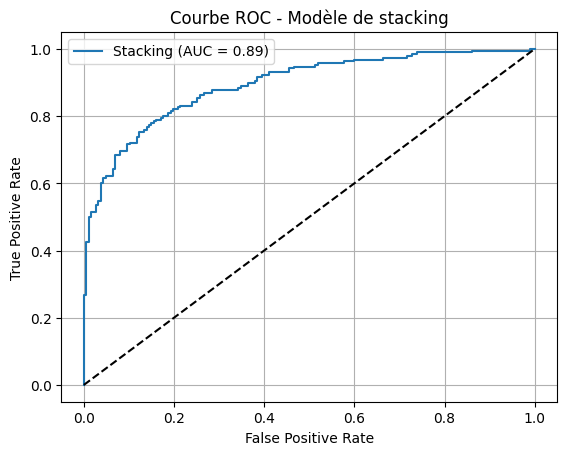

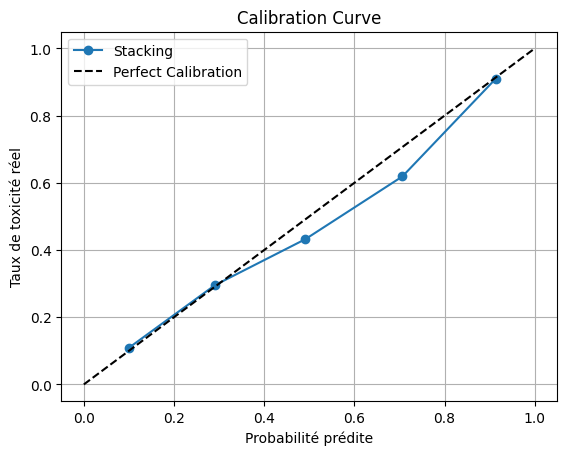

Accuracy: 0.8117


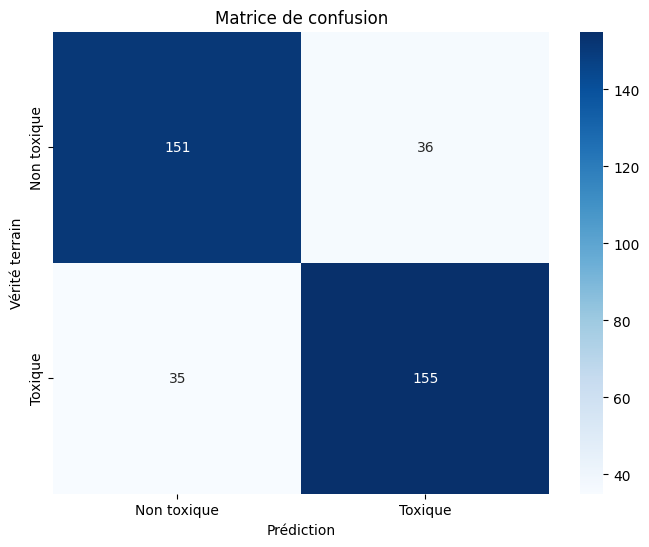

Cohen's Kappa: 0.6233


In [88]:
# AUC
auc_score = roc_auc_score(y_valid, y_pred)
print(f"AUC du stacking: {auc_score:.4f}")

# ROC curve
fpr, tpr, _ = roc_curve(y_valid, y_pred)
plt.figure()
plt.plot(fpr, tpr, label=f"Stacking (AUC = {auc_score:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Courbe ROC - Modèle de stacking")
plt.legend()
plt.grid()
plt.show()

# Calibration curve
prob_true, prob_pred = calibration_curve(y_valid, y_pred, n_bins=5)
plt.figure()
plt.plot(prob_pred, prob_true, marker='o', label='Stacking')
plt.plot([0,1], [0,1], 'k--', label='Perfect Calibration')
plt.xlabel('Probabilité prédite')
plt.ylabel('Taux de toxicité réel')
plt.title("Calibration Curve")
plt.legend()
plt.grid()
plt.show()


# Accuracy
accuracy = (y_valid == (y_pred > 0.5)).mean()
print(f"Accuracy: {accuracy:.4f}")

# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_valid, (y_pred > 0.5).astype(int))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non toxique', 'Toxique'], yticklabels=['Non toxique', 'Toxique'])
plt.xlabel('Prédiction')
plt.ylabel('Vérité terrain')
plt.title('Matrice de confusion')
plt.show()

# # Feature importance
# importances = meta_model.feature_importances_
# feature_names = X.columns
# indices = importances.argsort()[::-1]
# plt.figure(figsize=(10, 6))
# plt.title("Importance des caractéristiques")
# plt.bar(range(X.shape[1]), importances[indices], align='center')
# plt.xticks(range(X.shape[1]), feature_names[indices], rotation=45)
# plt.xlabel("Caractéristiques")
# plt.ylabel("Importance")
# plt.tight_layout()
# plt.show()

# Cohen's Kappa
from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(y_valid, (y_pred > 0.5).astype(int))
print(f"Cohen's Kappa: {kappa:.4f}")


### StackingNN

In [81]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, cohen_kappa_score

import pandas as pd
import numpy as np

# Charger les données
df = pd.read_csv("stacking_input.csv")
df_val = pd.read_csv("train/valid_20.csv")

X = df[['proba_dnn', 'proba_fp', 'proba_gnn', 'proba_trf']].values.astype(np.float32)
y = df_val["class"].values.astype(np.float32)

# Split train/val
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.001, random_state=42)

# Convert to tensors
X_train_t = torch.tensor(X_train)
y_train_t = torch.tensor(y_train).unsqueeze(1)
X_val_t = torch.tensor(X_val)
y_val_t = torch.tensor(y_val).unsqueeze(1)

# Define MoE Model
class StackingNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        # Le "gating network" prend les entrées et calcule des poids (softmax) pour chaque "expert"
        self.gating = nn.Sequential(
            nn.Linear(input_dim, 8),   # couche cachée
            nn.ReLU(),
            nn.Linear(8, input_dim),   # sortie = nb d'experts (ici 4)
            nn.Softmax(dim=1)          # normalise les poids pour chaque échantillon
        )

    def forward(self, x):
        gating_weights = self.gating(x)   # Calcule les poids pour chaque expert
        experts_output = x                # Ici, chaque "expert" est simplement la proba d'un modèle de base
        out = torch.sum(gating_weights * experts_output, dim=1, keepdim=True)  # Combine les sorties pondérées
        return out


# Training loop
model = StackingNN(input_dim=4)
optimizer = torch.optim.Adam(model.parameters(), lr=9e-3)
loss_fn = nn.BCELoss()

for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train_t)
    loss = loss_fn(y_pred, y_train_t)
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val_t)
            val_loss = loss_fn(val_pred, y_val_t)
            print(f"Epoch {epoch}: Train Loss={loss.item():.4f}, Val Loss={val_loss.item():.4f}")
            
# Sauvegarde du modèle
torch.save(model.state_dict(), "moe_model_final.pth")

# Évaluation
model.eval()
with torch.no_grad():
    final_preds = model(torch.tensor(X).float()).numpy().flatten()
    auc = roc_auc_score(y, final_preds)
    accuracy = (y == (final_preds > 0.5)).mean()
    cohen_kappa = cohen_kappa_score(y, (final_preds > 0.5).astype(int))

print(f"\n AUC: {auc:.4f}")
print(f" Accuracy: {accuracy:.4f}")
print(f" Cohen's Kappa: {cohen_kappa:.4f}")


Epoch 0: Train Loss=0.3892, Val Loss=0.2268
Epoch 100: Train Loss=0.3784, Val Loss=0.1528
Epoch 200: Train Loss=0.3752, Val Loss=0.1853
Epoch 300: Train Loss=0.3717, Val Loss=0.1868
Epoch 400: Train Loss=0.3695, Val Loss=0.1733
Epoch 500: Train Loss=0.3681, Val Loss=0.1715
Epoch 600: Train Loss=0.3670, Val Loss=0.1629
Epoch 700: Train Loss=0.3662, Val Loss=0.1573
Epoch 800: Train Loss=0.3656, Val Loss=0.1558
Epoch 900: Train Loss=0.3651, Val Loss=0.1555

 AUC: 0.9167
 Accuracy: 0.8444
 Cohen's Kappa: 0.6890


In [82]:
import pandas as pd

df_mlp= pd.read_csv("/Users/rayanedakhlaoui/Desktop/VivaAfricAI/Final/pred_sur_test/prediction_mlp.csv")
df_xgb  = pd.read_csv("/Users/rayanedakhlaoui/Desktop/VivaAfricAI/Final/pred_sur_test/prediction_xgb.csv")
df_trf = pd.read_csv("/Users/rayanedakhlaoui/Desktop/VivaAfricAI/Final/pred_sur_test/predictions_trf.csv")
df_gnn_2 = pd.read_csv("/Users/rayanedakhlaoui/Desktop/VivaAfricAI/Final/pred_sur_test/predictions_gnn.csv")

# Renommer les colonnes de probabilité pour éviter les confusions
df_mlp.rename(columns={'proba': 'proba_mlp'}, inplace=True)
df_xgb.rename(columns={'proba': 'proba_xgb'}, inplace=True)
df_trf.rename(columns={'proba_toxicite': 'proba_trf'}, inplace=True)
df_gnn_2.rename(columns={'predictions': 'proba_gnn'}, inplace=True)

# Fusion des prédictions
merged_final = df_mlp.merge(df_xgb, on='smiles')\
                      .merge(df_trf, on='smiles')\
                      .merge(df_gnn_2, on='smiles')
                      
merged_final.to_csv("stacking_input_test1.csv", index=False)

##  Prédiction on test_1.csv

In [83]:
import pandas as pd
import numpy as np
import torch
from torch import nn

# === Chargement des fichiers ===
df_mlp = pd.read_csv("/Users/rayanedakhlaoui/Desktop/VivaAfricAI/Final/pred_sur_test/prediction_mlp.csv")
df_xgb = pd.read_csv("/Users/rayanedakhlaoui/Desktop/VivaAfricAI/Final/pred_sur_test/prediction_xgb.csv")
df_trf = pd.read_csv("/Users/rayanedakhlaoui/Desktop/VivaAfricAI/Final/pred_sur_test/predictions_trf.csv")
df_gnn = pd.read_csv("/Users/rayanedakhlaoui/Desktop/VivaAfricAI/Final/pred_sur_test/predictions_gnn.csv")

df_mlp.rename(columns={'proba': 'proba_mlp'}, inplace=True)
df_xgb.rename(columns={'proba': 'proba_xgb'}, inplace=True)
df_trf.rename(columns={'proba_toxicite': 'proba_trf'}, inplace=True)
df_gnn.rename(columns={'predictions': 'proba_gnn'}, inplace=True)

# === Fusion des prédictions ===
merged = df_mlp.merge(df_xgb, on='smiles')\
               .merge(df_trf, on='smiles')\
               .merge(df_gnn, on='smiles')

# === Préparation des données ===
X_test = merged[['proba_mlp', 'proba_xgb', 'proba_trf', 'proba_gnn']].values.astype(np.float32)
X_test_t = torch.tensor(X_test)


# === Chargement du modèle ===

class MixtureOfExperts(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.gating = nn.Sequential(
            nn.Linear(input_dim, 8),
            nn.ReLU(),
            nn.Linear(8, input_dim),
            nn.Softmax(dim=1)  # pondérations
        )

    def forward(self, x):
        gating_weights = self.gating(x)         
        experts_output = x                     
        out = torch.sum(gating_weights * experts_output, dim=1, keepdim=True) 
        return out


model = MixtureOfExperts(input_dim=4)
model.load_state_dict(torch.load("moe_model_final.pth"))
model.eval()

# === Prédiction ===
with torch.no_grad():
    y_pred_proba = model(X_test_t).numpy().flatten()

y_pred = (y_pred_proba > 0.5).astype(int)

# === Calcul de la "fiabilité" comme différence entre prédiction binaire et proba ===
y_dist = pd.DataFrame({
    'SMILES': merged['smiles'],
    'diff': np.abs(y_pred_proba - y_pred),  # plus petit = plus fiable
    'class': y_pred
})


# === Tri des molécules par fiabilité croissante ===
y_dist_sorted = y_dist.sort_values(by='diff', ascending=True)

# === Retenir les 200 molécules les plus fiables ===

y_final = y_dist_sorted[['SMILES', 'class']]

print(y_final.head(20))

# === Sauvegarde dans un seul fichier : pred1.csv ===
y_final.to_csv("pred1.csv")



                                                SMILES  class
246  CN(CCOc1ccc([N+](=O)[O-])cc1)CCc1ccc([N+](=O)[...      1
541           N#Cc1ccc(CCN2CCN(CCc3ccc(C#N)cc3)CC2)cc1      1
156                         CCCCN(CC)CC#CCCc1ccc(C)cc1      1
577          NC1CCc2ccc(CCN3CCN(c4nsc5ccccc45)CC3)cc21      1
411              Cc1cc(F)ccc1C1CCN(CC2Cc3ccccc3CN2)CC1      1
90                            CC(CS)C(=O)N1CCCC1C(=O)O      0
279                  CNCc1cc(C#N)ccc1Oc1ccc(Cl)c(Cl)c1      1
177                 CCN(CC)CCCN(c1ccccc1)C1Cc2ccccc2C1      1
157                        CCCCN(CC)CC#CCOc1ccc(Cl)cc1      1
155                       CCCCN(CC)CC#CC#Cc1ccc(Cl)cc1      1
656                  O=C(O)c1ccc(O)c2ncc(N3CCOCC3)cc12      0
520     Fc1ccc2cccc(N3CCN(CCCOc4ccc5c(c4)CNC5)CC3)c2c1      1
431           Cc1ccc(CCc2cccc(CCc3ccc(C)cc3)[n+]2C)cc1      1
227               CN(C)CCC1=C(Cc2cnccn2)c2ccc(Cl)cc2C1      1
158                          CCCCN(CC)CC=Cc1ccc(Cl)cc1      1
103     

In [84]:
merged['mean_proba'] = merged[['proba_mlp', 'proba_xgb', 'proba_trf', 'proba_gnn']].mean(axis=1)
merged['prediction'] = (merged['mean_proba'] > 0.5).astype(int)
y2=merged[['smiles', 'prediction']]
y2.columns = ['SMILES', 'prediction']
print(y_final.columns)
ybis= y_final.merge(y2, on='SMILES', how='outer')
ybis.to_csv("predmean.csv")

Index(['SMILES', 'class'], dtype='object')


In [85]:
print(y_final['class'].value_counts())
print(y2['prediction'].value_counts())

class
0    464
1    286
Name: count, dtype: int64
prediction
0    447
1    303
Name: count, dtype: int64
